In [6]:
import numpy as np
import itertools
import pandas as pd
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
SOX9 = 'CAACAATGG'
DEL_SEQ = 'CAATGGTCA'
sequence_dict = SeqIO.to_dict(SeqIO.parse('data/en13_seq.fa', format='fasta'))
seq = str(sequence_dict['chren13_WT'].seq)
SOX_idx = seq.find(SOX9)
SOX_end = SOX_idx + len(SOX9)


def plot_histplot_with_labels(df, labels):
    # Create a seaborn histplot with kde=True and stat=density
    plt.figure(figsize=(8, 6))
    fig = sns.histplot(data=df, x=df[3], kde=True, stat="density")

    colors2 = sns.color_palette('Set1')
    percentile_98 = np.percentile(df[3], 98)
    plt.axvline(percentile_98, color=colors2[len(labels)], linestyle='dashdot', linewidth=1, label=f'98 percentile')

    
    # Iterate through each label in the list
    for i in range(len(labels)):
        label = labels[i]
        # Find the location of the label in df[0]
        label_index = df[df[0] == label].index[0]

        # Get the corresponding value from df[3]
        value = df.at[label_index, 3]


        # Plot the label name above the bin
        seq = label.replace('chr_','')
        plt.annotate(seq, xy=(value + 0.174, (i + 1)*0.3), xytext=(value, 0.02), textcoords='offset points', ha='center', fontsize=10, color=colors2[i])
        plt.axvline(value, color=colors2[i], linestyle='--', linewidth=1, label=seq)

    # Show the plot
    plt.xlabel('Binding Score')
    plt.ylabel('Frequency')
    plt.title('9-mers deepBind score distribution (enh13 SOX9)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    # return fig



# DeepBind SOX9 binding score distribution Experiment 

## Objective
The objective of this experiment was to assess the SOX9 binding capability of all possible 9-mer sequences within enh13,  predicted by deepBind model.

## Experimental Steps

1. **Sequence Generation**: All possible 9-mer sequences, totaling 4^9 sequences, were generated.

2. **Sequence Insertion**: These generated sequences were inserted into the SOX9 TFBS region of enhancer enh13.


In [8]:
# Define the alphabet of letters
letters = ['A', 'G', 'C', 'T']

# Define the desired length of strings
length = 9


# Generate the fasta file for the experiment
def generate_fasta(seq_series,seq):
    subseq = ''.join(seq_series.tolist())
    name = f">chr_{subseq}"
    cur_seq = seq[:SOX_idx] + subseq + seq[SOX_idx + len(SOX9):]
    return pd.Series([name,cur_seq])

df = pd.DataFrame(itertools.product(letters, repeat=length))
pd.Series(df.apply(lambda x: generate_fasta(x,seq), axis=1).to_numpy().flatten()).to_csv('data/enh13_XOS9_exp.fa', index=False, header=None)


3. **BED file Generation**: A matching bed file was generated

In [9]:

def generate_BED(seq_series):
    subseq = ''.join(seq_series.tolist())
    name = f"chr_{subseq}"
    return f"{name}\t{SOX_idx}\t{SOX_end}"
    
df.apply(lambda x: generate_BED(x), axis=1).to_csv('data/enh13_XOS9_exp.bed', index=False, header=None)




4. **Model Prediction**: The deepBind model was utilized to predict the binding capability of SOX9 for each of the generated sequences.


```bash
conda activate kipoi-DeepBind
bin/deepBind.sh data/enh13_XOS9_exp.bed data/enh13_XOS9_exp.fa DeepBind/Homo_sapiens/TF/D00649.002_SELEX_SOX9
```

In [10]:
result= pd.read_csv('data/SOX9_enh13_XOS9_exp.tsv',sep='\t', header=None)
display(result.head())

,0,1,2,3
0,chr_AAAAAAAAA,150,159,0.678811
1,chr_AAAAAAAAG,150,159,0.575124
2,chr_AAAAAAAAC,150,159,0.577960
3,chr_AAAAAAAAT,150,159,0.575124
4,chr_AAAAAAAGA,150,159,0.575124


4. **Result Analysis**: The results obtained from the model prediction were analyzed, and a score distribution was plotted.


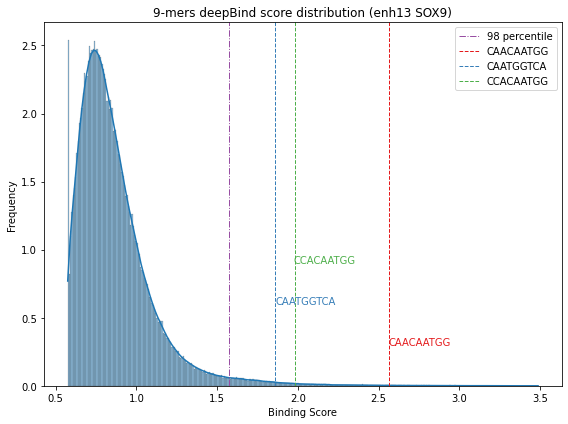

In [17]:
plot_histplot_with_labels(result, [f'chr_{SOX9}',f'chr_{DEL_SEQ}', 'chr_CCACAATGG'])

**Vertical Lines**: Vertical lines were added to the plot at the following key points:
   - Green - The 98th percentile of the model's score distribution.
   - Red - The original sequence within enh13.
   - Blue - A sequence with a 3bp deletion
